Importing libraries for machine learning and image display

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
!unzip saved_model_20.zip

Archive:  saved_model_20.zip
   creating: saved_model_20/
  inflating: saved_model_20/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/saved_model_20/
  inflating: __MACOSX/saved_model_20/._.DS_Store  
   creating: saved_model_20/my_model_20/
  inflating: saved_model_20/my_model_20/.DS_Store  
   creating: __MACOSX/saved_model_20/my_model_20/
  inflating: __MACOSX/saved_model_20/my_model_20/._.DS_Store  
  inflating: saved_model_20/my_model_20/keras_metadata (1).pb  
  inflating: __MACOSX/saved_model_20/my_model_20/._keras_metadata (1).pb  
  inflating: saved_model_20/my_model_20/fingerprint (1).pb  
  inflating: __MACOSX/saved_model_20/my_model_20/._fingerprint (1).pb  
  inflating: saved_model_20/my_model_20/saved_model (3).pb  
  inflating: __MACOSX/saved_model_20/my_model_20/._saved_model (3).pb  
   creating: saved_model_20/my_model_20/variables/
  inflating: saved_model_20/my_model_20/variables/variables (1).index  
   creating: __MACOSX/saved_model_20/my_model_20/variabl

Loading previously saved model

In [6]:
new_model = keras.models.load_model('saved_model_20/my_model_20')
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

Loading the dataset used for training and testing from tfds.

Each image in the dataset has a corresponding mask (class label):

Class 1: Pixel belonging to the object.

Class 2: Pixel bordering the object.

Class 3: None of the above/a surrounding pixel.

In [7]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7CHCH5/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7CHCH5/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Image color values are normalized to the [0, 1] range

In [8]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Resizing each image of the dataset to be the same size for easy comparison

In [9]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Getting train and test sets

In [10]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [11]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Flipping the image for data augmentation - increases diversity of the dataset

In [12]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Displaying the results of the model

In [13]:
test_batches = test_images.batch(BATCH_SIZE)

In [14]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [16]:
def display_edit(image, mask):

  img = np.array(image)

  for r in range(mask.shape[0]):
    for c in range(mask.shape[0]):
      if(mask[r][c]==1):
        img[r,c] = (0, 0, 0)
      elif(mask[r][c]==2):
        img[r,c] = (0,0,0)
  
  plt.title('Black Background')
  plt.imshow(tf.keras.utils.array_to_img(img))
  plt.axis('off')
  # plt.savefig('rb1.png')
  plt.show()


In [17]:
def display_edit_withoutline(image, mask):

  img = np.array(image)

  for r in range(mask.shape[0]):
    for c in range(mask.shape[0]):
      if(mask[r][c]==1):
        img[r,c] = (0, 0, 0)
      elif(mask[r][c]==2):
        img[r,c] = (1,1,1)
  
  plt.title('Black Background with White Outline')
  plt.imshow(tf.keras.utils.array_to_img(img))
  plt.axis('off')
  # plt.savefig('rbwo1.png')
  plt.show()

Displays predicted masks and images after removing the background (with and without outline)

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = new_model.predict(image)
      # display([image[0], mask[0], create_mask(pred_mask)])
      display_edit_withoutline(image[0],create_mask(pred_mask))
      display_edit(image[0],create_mask(pred_mask))
  else:
    display([sample_image, sample_mask,
             create_mask(new_model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 3s 1s/step


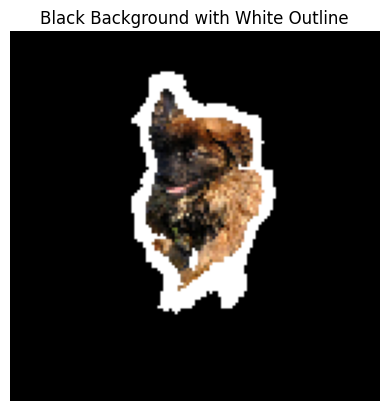

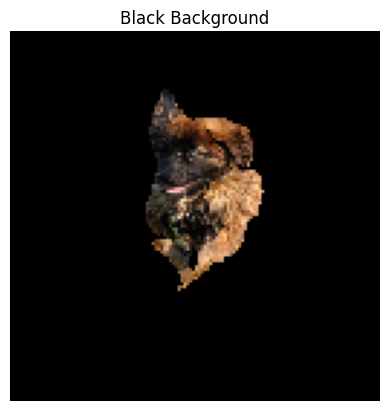

In [21]:
show_predictions(test_batches, 1)